In [1]:
!git clone https://github.com/facebookresearch/sam2
%cd /content/sam2
!pip install -e .

fatal: destination path 'sam2' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/sam2'
/home/multi-gpu/ai_res/Khadija/sam2


/home/multi-gpu/anaconda3/envs/sam2_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


Obtaining file:///home/multi-gpu/ai_res/Khadija/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=13869 sha256=2ae01f603270fa2cff4db3e1dd6eb88b49597cb78bd5f4f3014d7f678b6d7cab
  Stored in directory: /tmp/pip-ephem-wheel-cache-5oty1fzh/wheels/9b/63/5c/fb5ca0d7c60b3b590c276b816f77c9e56cf669884a2dba9e18
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0


In [2]:
%cd checkpoints
!bash download_ckpts.sh
%cd ..


/home/multi-gpu/ai_res/Khadija/sam2/checkpoints
--2026-01-20 11:36:06--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 

/home/multi-gpu/anaconda3/envs/sam2_env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


2600:9000:266c:600:13:6e38:acc0:93a1, 2600:9000:266c:ec00:13:6e38:acc0:93a1, 2600:9000:266c:1c00:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:266c:600:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt.5’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M  11.5MB/s    in 13s     

2026-01-20 11:36:19 (11.6 MB/s) - ‘sam2.1_hiera_tiny.pt.5’ saved [156008466/156008466]

--2026-01-20 11:36:19--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:266c:5200:13:6e38:acc0:93a1, 2600:9000:266c:600:13:6e38:acc0:93a1, 2600:9000:266c:ec00:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:266c:5200:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200

In [ ]:
# from google.colab import files
# uploaded = files.upload()  # upload .mp4
# video_path = list(uploaded.keys())[0]
video_path = ""  # or specify your video path here


In [13]:
import cv2, os

frames_dir = "video_frames"
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f"{frames_dir}/{idx:05d}.jpg", frame)
    idx += 1
cap.release()

print("Total frames:", idx)


Total frames: 231


In [14]:
import cv2

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_MSEC, 4000)  # 4 seconds

ret, frame = cap.read()
if ret:
    cv2.imwrite("first_frame.jpg", frame)
    print("Saved anchor frame as first_frame.jpg")
else:
    print("Failed to extract anchor frame")

cap.release()


Saved anchor frame as first_frame.jpg


In [6]:
import shutil, os

os.makedirs("video_frames_orig", exist_ok=True)

# Move original frames
for f in os.listdir("video_frames"):
    shutil.move(
        os.path.join("video_frames", f),
        os.path.join("video_frames_orig", f)
    )

# Insert anchor
shutil.copy("first_frame.jpg", "video_frames/00000.jpg")

# Reinsert original frames shifted by +1
orig = sorted(os.listdir("video_frames_orig"))
for i, f in enumerate(orig):
    shutil.copy(
        os.path.join("video_frames_orig", f),
        os.path.join("video_frames", f"{i+1:05d}.jpg")
    )

print("Anchor frame prepended.")


Anchor frame prepended.


In [8]:
import os, shutil

SRC = "video_frames"
CHUNK_DIR = "chunks"
CHUNK_SIZE = 200

if os.path.exists(CHUNK_DIR):
    shutil.rmtree(CHUNK_DIR)
os.makedirs(CHUNK_DIR)

frames = sorted(os.listdir(SRC))

for i in range(0, len(frames), CHUNK_SIZE):
    chunk_path = f"{CHUNK_DIR}/chunk_{i//CHUNK_SIZE:03d}"
    os.makedirs(chunk_path)
    for f in frames[i:i+CHUNK_SIZE]:
        shutil.copy(os.path.join(SRC, f), os.path.join(chunk_path, f))

print("Chunks created:", len(os.listdir(CHUNK_DIR)))


Chunks created: 1


In [9]:
import sys, os
from sam2.build_sam import build_sam2_video_predictor
from hydra import initialize_config_module
from hydra.core.global_hydra import GlobalHydra

if '/content/sam2' not in sys.path:
    sys.path.insert(0, '/content/sam2')

# Hydra fix for notebooks
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize_config_module("sam2.configs", version_base="1.3")

print("Hydra initialized.")


Hydra initialized.


In [8]:
import sys
import os
from sam2.build_sam import build_sam2_video_predictor
from hydra import compose, initialize_config_module
from hydra.core.global_hydra import GlobalHydra

# Ensure Python's path includes the repository root if it's not already there.
# This helps with package discovery for `pkg://` paths that Hydra might use.
if '/content/sam2' not in sys.path:
    sys.path.insert(0, '/content/sam2')

# Create __init__.py files to make 'sam2/configs' and 'sam2/configs/sam2.1' recognized as Python packages.
# This is necessary for hydra.initialize_config_module to find the config module.
os.makedirs('/content/sam2/sam2/configs/sam2.1', exist_ok=True)
with open('/content/sam2/sam2/configs/__init__.py', 'a'):
    pass # Create an empty __init__.py
with open('/content/sam2/sam2/configs/sam2.1/__init__.py', 'a'):
    pass # Create an empty __init__.py


# Clear any previously initialized Hydra state to prevent 'AlreadyInitializedError'
# and ensure a clean state for configuration loading.
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

# Initialize Hydra programmatically to find configs within the 'sam2.configs' Python module.
# The 'sam2.configs' module corresponds to the 'configs' directory inside the 'sam2' package.
initialize_config_module(config_module="sam2.configs", version_base="1.3")

# `model_cfg` specifies the config file's path relative to the `config_module`
# set in `initialize_config_module`. The YAML file is `sam2.1_hiera_b+.yaml` inside the `sam2.1` directory.
model_cfg = "sam2.1/sam2.1_hiera_t.yaml"
checkpoint = "checkpoints/sam2.1_hiera_tiny.pt"

# The `build_sam2_video_predictor` function internally uses Hydra's `compose`.
# With Hydra now globally initialized via `initialize_config_module`,
# its internal `compose` call should successfully locate and load the specified `model_cfg`.
predictor = build_sam2_video_predictor(
    config_file=model_cfg,
    ckpt_path=checkpoint,
    device="cuda"
)

print("SAM2 Video Predictor initialized successfully.")

SAM2 Video Predictor initialized successfully.


In [15]:
import cv2
import numpy as np

img = cv2.imread("video_frames/00000.jpg")
h, w, _ = img.shape

annotated = img.copy()

STEP = 25          # distance between coordinate labels
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.4
THICKNESS = 1
COLOR = (0, 255, 0)

# ---- X-axis labels (top) ----
for x in range(0, w, STEP):
    cv2.putText(
        annotated,
        str(x),
        (x + 2, 15),
        FONT,
        FONT_SCALE,
        COLOR,
        THICKNESS,
        cv2.LINE_AA
    )
    cv2.line(annotated, (x, 0), (x, 5), COLOR, 1)

# ---- Y-axis labels (left) ----
for y in range(0, h, STEP):
    cv2.putText(
        annotated,
        str(y),
        (2, y + 12),
        FONT,
        FONT_SCALE,
        COLOR,
        THICKNESS,
        cv2.LINE_AA
    )
    cv2.line(annotated, (0, y), (5, y), COLOR, 1)

cv2.imwrite("first_frame_with_axes.jpg", annotated)
print("Saved: first_frame_with_axes.jpg")


Saved: first_frame_with_axes.jpg


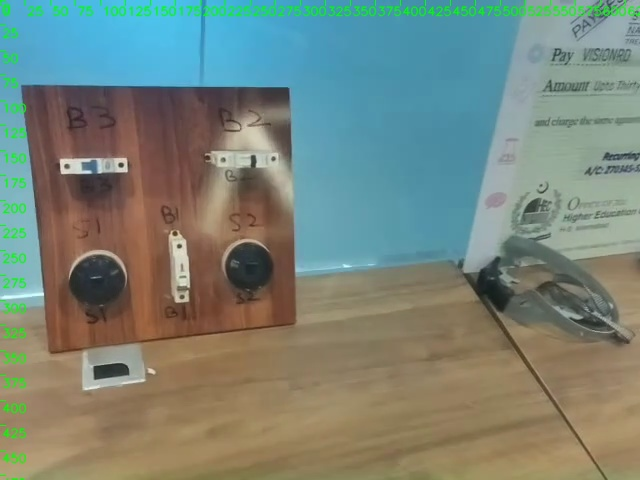

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = cv2.imread("first_frame_with_axes.jpg")
cv2_imshow(img)


In [11]:
import ipywidgets as widgets
from IPython.display import display

x1 = widgets.IntSlider(0, 0, img.shape[1])
y1 = widgets.IntSlider(0, 0, img.shape[0])
x2 = widgets.IntSlider(100, 0, img.shape[1])
y2 = widgets.IntSlider(100, 0, img.shape[0])

display(x1, y1, x2, y2)

def get_box():
    return [x1.value, y1.value, x2.value, y2.value]

box = get_box()
print("Selected box:", box)


IntSlider(value=0, max=960)

IntSlider(value=0, max=540)

IntSlider(value=100, max=960)

IntSlider(value=100, max=540)

Selected box: [0, 0, 100, 100]


In [21]:
import cv2, numpy as np
from tqdm import tqdm

frames_dir = "video_frames"
masks_dir = "/home/multi-gpu/ai_res/Khadija/sam2/notebooks/masks"
output_path = "sam2_overlay.mp4"

frames = sorted(os.listdir(frames_dir))
masks = sorted(os.listdir(masks_dir))
num = min(len(frames), len(masks))

frame0 = cv2.imread(os.path.join(frames_dir, frames[0]))
h, w, _ = frame0.shape

writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*"mp4v"),
    30,
    (w, h)
)

for i in tqdm(range(num)):
    frame = cv2.imread(os.path.join(frames_dir, frames[i]))
    mask = np.squeeze(np.load(os.path.join(masks_dir, masks[i]))) > 0

    overlay = frame.copy()
    overlay[mask] = (0, 255, 0)

    blended = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)
    writer.write(blended)

writer.release()
print("Saved:", output_path)


100%|██████████| 231/231 [00:02<00:00, 91.14it/s]

Saved: sam2_overlay.mp4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
files.download("sam2_overlay.mp4")
